In [1]:
# Import Libraries
import numpy as np
import json

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array, load_img
from keras.applications.imagenet_utils import preprocess_input

Using TensorFlow backend.


In [2]:
# Upload VGG16
vgg16 = VGG16(weights='imagenet')

In [3]:
vgg16.save('vgg16.h5')

In [4]:
def prepare_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

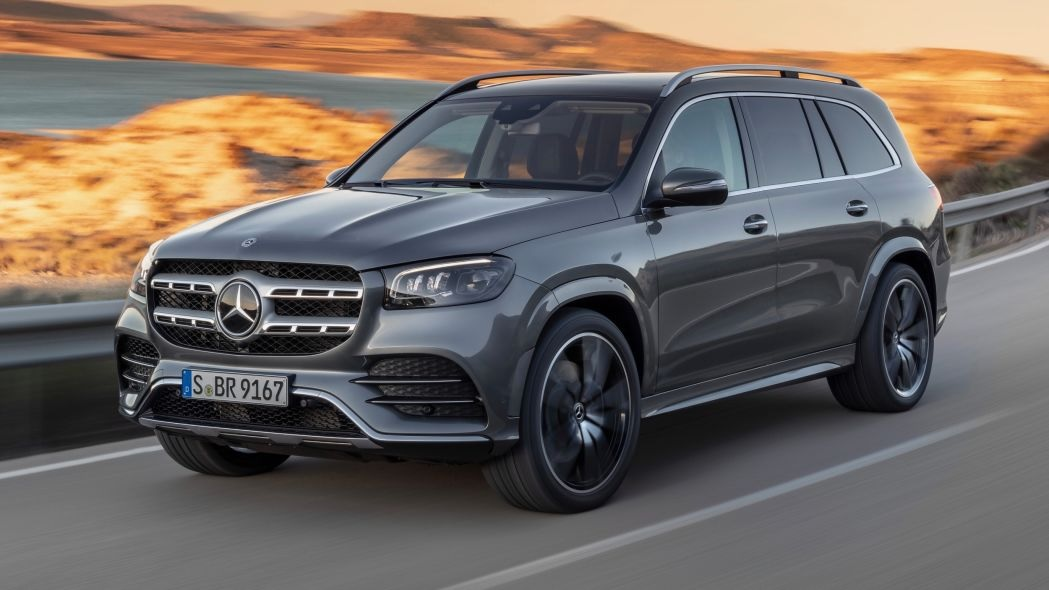

In [5]:
from IPython.display import Image, display
display(Image(filename='car.jpg'))
y = prepare_image('car.jpg')

In [6]:
preds = vgg16.predict(y)

In [7]:
preds

array([[3.09868881e-07, 4.72167500e-07, 6.80877861e-08, 2.79784800e-08,
        1.06085764e-07, 1.57430676e-07, 4.22610249e-08, 1.52266366e-05,
        4.51326969e-06, 3.14877525e-06, 4.17973041e-07, 2.92337887e-07,
        2.07900734e-06, 4.21809659e-07, 2.27234594e-07, 1.03055243e-06,
        6.78703145e-07, 9.03435989e-07, 1.89448588e-06, 4.81664074e-06,
        1.23911980e-06, 2.76092487e-06, 5.17727858e-06, 1.19429651e-05,
        4.07793959e-06, 1.87804244e-06, 1.04236415e-06, 2.26059478e-06,
        9.58285796e-07, 1.02484400e-07, 5.66635799e-06, 2.08061783e-06,
        5.64934999e-06, 4.10212924e-05, 1.95309796e-04, 5.58233842e-05,
        4.52371678e-05, 1.70594794e-05, 1.39224585e-06, 4.85702287e-07,
        1.02344370e-06, 4.37092467e-06, 7.45400848e-06, 1.11794600e-06,
        4.26093447e-06, 4.23290339e-06, 4.97473195e-07, 2.22679716e-07,
        1.33659694e-06, 2.68980966e-06, 8.70455438e-07, 6.05362743e-07,
        1.31159577e-05, 9.90123863e-06, 7.59787281e-06, 1.789044

In [8]:
CLASS_INDEX = None
CLASS_INDEX_PATH = 'imagenet_class_index.json'

In [9]:
def get_predictions(preds,top=10):
    global CLASS_INDEX
    
    #Load the jason file
    CLASS_INDEX = json.load(open(CLASS_INDEX_PATH))
    
    #get the results
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [10]:
print (get_predictions(preds, top=10))

[[('n03930630', 'pickup', 0.32367623), ('n02814533', 'beach_wagon', 0.22085436), ('n02974003', 'car_wheel', 0.1303094), ('n03100240', 'convertible', 0.06887075), ('n04285008', 'sports_car', 0.06299447), ('n03459775', 'grille', 0.053051263), ('n04037443', 'racer', 0.037780445), ('n03594945', 'jeep', 0.029325364), ('n03770679', 'minivan', 0.022378985), ('n04461696', 'tow_truck', 0.012042417)]]


### First Check - category list creation

In [11]:
from collections import Counter, defaultdict
import os
import pickle as pk

### Using VGG16 model

In [12]:
def get_car_categories():
    d = defaultdict(float)
    img_list = os.listdir('./training/01-whole')
    for i, img_path in enumerate(img_list):
        img = prepare_image('./training/01-whole/'+img_path)
        out = vgg16.predict(img)
        top = get_predictions(out, top=5)
        for j in top[0]:
            d[j[0:2]] += j[2]
        if i % 100 == 0:
            print (i, '/', len(img_list), 'complete')
    return Counter(d)

In [13]:
cat_counter=get_car_categories()

0 / 920 complete
100 / 920 complete
200 / 920 complete
300 / 920 complete
400 / 920 complete
500 / 920 complete
600 / 920 complete
700 / 920 complete
800 / 920 complete
900 / 920 complete


In [14]:
with open('cat_counter.pk', 'wb') as f: 
    pk.dump(cat_counter,f,-1)

In [42]:
# This piece of code will be used to load already saved cat_counter
#with open('cat_counter.pk', 'rb') as f:
 #   cat_counter = pk.load(f)

In [15]:
cat_list  = [k for k, v in cat_counter.most_common()[:27]]

In [16]:
cat_list

[('n03770679', 'minivan'),
 ('n04285008', 'sports_car'),
 ('n03100240', 'convertible'),
 ('n02814533', 'beach_wagon'),
 ('n03930630', 'pickup'),
 ('n03670208', 'limousine'),
 ('n04037443', 'racer'),
 ('n03594945', 'jeep'),
 ('n03769881', 'minibus'),
 ('n04461696', 'tow_truck'),
 ('n03459775', 'grille'),
 ('n02930766', 'cab'),
 ('n02974003', 'car_wheel'),
 ('n03796401', 'moving_van'),
 ('n03977966', 'police_van'),
 ('n04252225', 'snowplow'),
 ('n02701002', 'ambulance'),
 ('n04065272', 'recreational_vehicle'),
 ('n04467665', 'trailer_truck'),
 ('n03445924', 'golfcart'),
 ('n03345487', 'fire_engine'),
 ('n03791053', 'motor_scooter'),
 ('n03776460', 'mobile_home'),
 ('n04252077', 'snowmobile'),
 ('n02704792', 'amphibian'),
 ('n03417042', 'garbage_truck'),
 ('n02965783', 'car_mirror')]

### Check if car or not

In [17]:
def car_categories_gate(image_path, cat_list):
    img = prepare_image(image_path)
    out = vgg16.predict(img)
    top = get_predictions(out, top=5)
    print ("Validating that this is a picture of your car...")
    for j in top[0]:
        if j[0:2] in cat_list:
            print (j[0:2])
            return "Validation complete - proceed to damage evaluation"
    return "Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again."

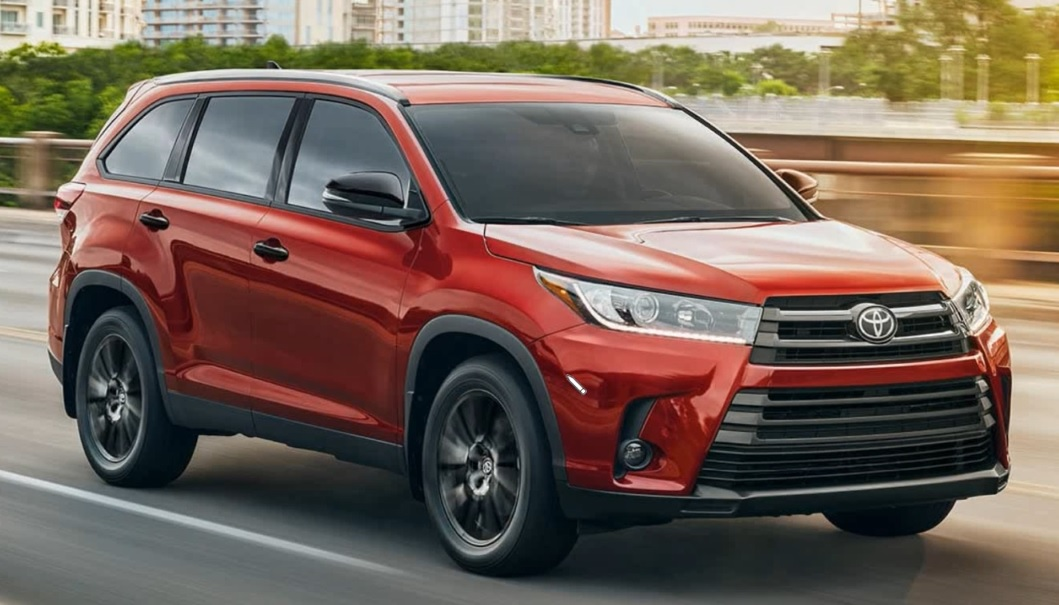

Validating that this is a picture of your car...
('n03930630', 'pickup')


'Validation complete - proceed to damage evaluation'

In [18]:
display(Image(filename='car2.jpg'))
car_categories_gate('car2.jpg', cat_list)

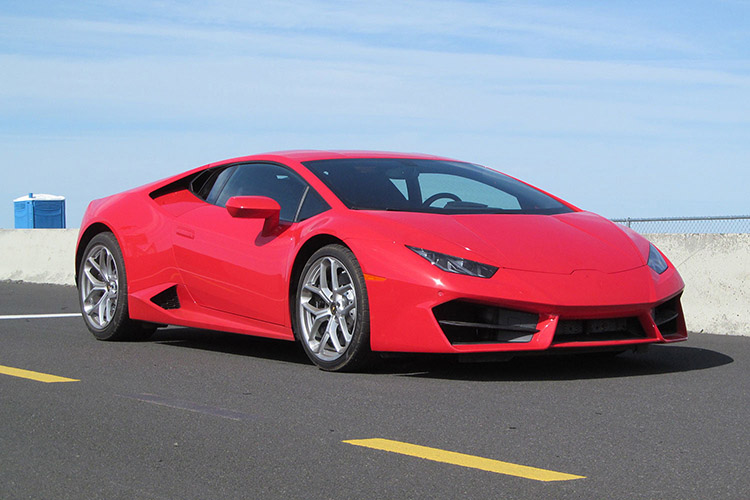

Validating that this is a picture of your car...
('n04285008', 'sports_car')


'Validation complete - proceed to damage evaluation'

In [19]:
display(Image(filename='car-1.jpg'))
car_categories_gate('car-1.jpg', cat_list)

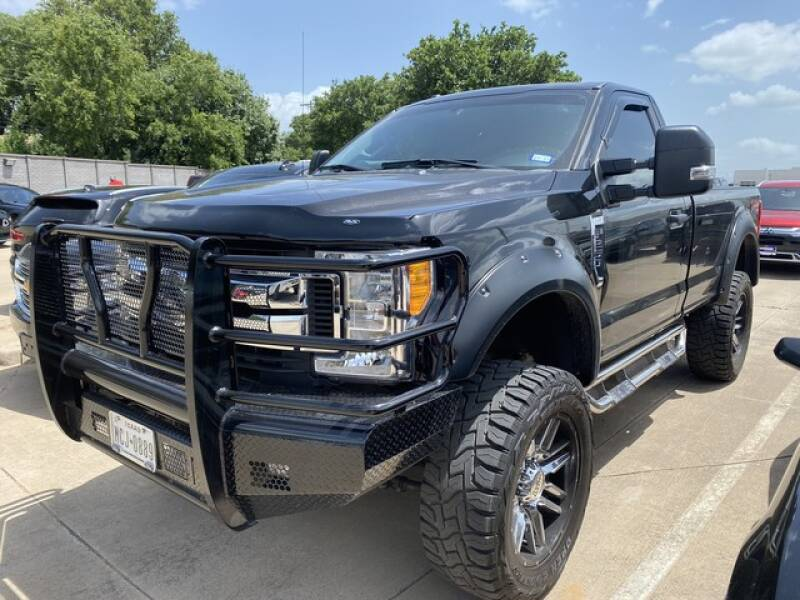

Validating that this is a picture of your car...
('n03594945', 'jeep')


'Validation complete - proceed to damage evaluation'

In [20]:
display(Image(filename='car-2.jpg'))
car_categories_gate('car-2.jpg', cat_list)

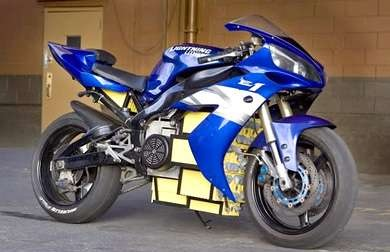

Validating that this is a picture of your car...
('n03791053', 'motor_scooter')


'Validation complete - proceed to damage evaluation'

In [21]:
display(Image(filename='motorcycle.jpg'))
car_categories_gate('motorcycle.jpg', cat_list)

#### Not a car?

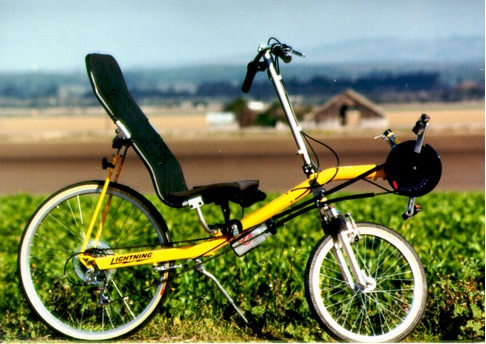

Validating that this is a picture of your car...


'Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again.'

In [22]:
display(Image(filename='bicycle.jpg'))
car_categories_gate('bicycle.jpg', cat_list)

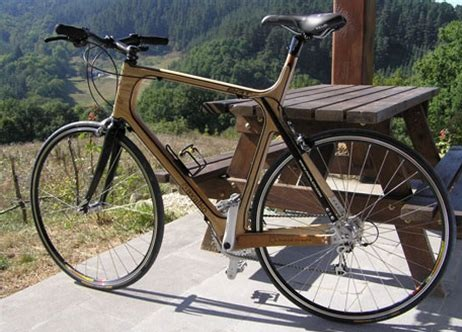

Validating that this is a picture of your car...


'Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again.'

In [23]:
display(Image(filename='bicycle2.jpg'))
car_categories_gate('bicycle2.jpg', cat_list)

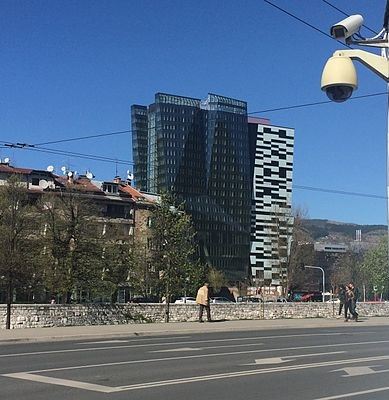

Validating that this is a picture of your car...


'Are you sure this is a picture of your car? Please take another picture (try a different angle or lighting) and try again.'

In [24]:
display(Image(filename='city.jpg'))
car_categories_gate('city.jpg', cat_list)